# Accelerated Video Decoding with NVDEC

This tutorial shows how to use Nvidia's hardware video decoding (NVDEC)† with TorchAudio.

**NOTE**

> This tutorial is authored in Google Colab, and is tailored for Google Colab's specification.
>
> Please checkout this tutorial in Google Colab https://colab.research.google.com/drive/1DDah_IaGULEO66CfQWltRqaVheBkiXdN
>
> If you apply this in your system, please adjust the configurations accordingly.

To use NVDEC with TorchAudio, the following items are required.

1. Nvidia GPU with hardware video encoder.
2. FFmpeg libraires compiled with NVDEC support.
3. PyTorch / TorchAudio with CUDA support.

TochAudio's binary distributions are compiled against FFmpeg 4 libraires, and they contain the necessary implementation to use the hardware-based decoding.

In the following sections, we build FFmpeg 4 libraires with NVDEC support and use the hardware acceleration through TorchAudio's `StreamReader` API. We compare the time it takes to decode the same MP4 video with CPU and NVDEC.

† For details of NVDEC and FFmpeg, please refer to the following articles.

* https://docs.nvidia.com/video-technologies/video-codec-sdk/nvdec-video-decoder-api-prog-guide/
* https://docs.nvidia.com/video-technologies/video-codec-sdk/ffmpeg-with-nvidia-gpu/#compiling-ffmpeg
* https://developer.nvidia.com/blog/nvidia-ffmpeg-transcoding-guide/


## Check the available GPU

In [1]:
!nvidia-smi

Sun May 15 00:01:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Update PyTorch and TorchAudio with nightly builds

Until TorchAudio 0.12 is released and become available, we need to use the nightly build of PyTorch and TorchAudio.

In [2]:
!pip3 uninstall -y torchaudio torch
!pip3 install --pre torch torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113

Found existing installation: torchaudio 0.11.0+cu113
Uninstalling torchaudio-0.11.0+cu113:
  Successfully uninstalled torchaudio-0.11.0+cu113
Found existing installation: torch 1.11.0+cu113
Uninstalling torch-1.11.0+cu113:
  Successfully uninstalled torch-1.11.0+cu113
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
     |████████████████████████████████| 2097.5 MB 1.4 kB/s 
     |████████████████████████████████| 3.7 MB 23.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.12.0.dev20220514+cu113 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.12.0.dev20220514+cu113 which is incompatible.


## Build FFmpeg libraries with Nvidia NVDEC support


### Install NVIDIA Video Codec Headers

To build FFmpeg with NVDEC, first we install the headers that FFmpeg uses to interact with Video Codec SDK.

In [3]:
!git clone https://git.videolan.org/git/ffmpeg/nv-codec-headers.git
!cd nv-codec-headers && sudo make install

Cloning into 'nv-codec-headers'...
remote: Enumerating objects: 808, done.
remote: Counting objects: 100% (808/808), done.
remote: Compressing objects: 100% (688/688), done.
remote: Total 808 (delta 434), reused 0 (delta 0)
Receiving objects: 100% (808/808), 155.22 KiB | 582.00 KiB/s, done.
Resolving deltas: 100% (434/434), done.
sed 's#@@PREFIX@@#/usr/local#' ffnvcodec.pc.in > ffnvcodec.pc
install -m 0755 -d '/usr/local/include/ffnvcodec'
install -m 0644 include/ffnvcodec/*.h '/usr/local/include/ffnvcodec'
install -m 0755 -d '/usr/local/lib/pkgconfig'
install -m 0644 ffnvcodec.pc '/usr/local/lib/pkgconfig'


### Download FFmpeg source code

Next we download the source code of FFmpeg. Any version later than 4.1 should work. We use 4.4.2 here.

In [4]:
!wget -q https://github.com/FFmpeg/FFmpeg/archive/refs/tags/n4.4.2.tar.gz
!tar -xf n4.4.2.tar.gz
!mv FFmpeg-n4.4.2 ffmpeg

### Install FFmpeg build and runtime dependencies

In the later test, we use H264-encoded MP4 video streamed over HTTPS protocol, so we install the libraries for them.

In [5]:
!apt update
!apt install -y yasm libx264-dev libgnutls28-dev


... Omitted for brevity ...

Setting up libx264-dev:amd64 (2:0.152.2854+gite9a5903-2) ...
Setting up yasm (1.3.0-2build1) ...
Setting up libunbound2:amd64 (1.6.7-1ubuntu2.4) ...
Setting up libp11-kit-dev:amd64 (0.23.9-2ubuntu0.1) ...
Setting up libtasn1-6-dev:amd64 (4.13-2) ...
Setting up libtasn1-doc (4.13-2) ...
Setting up libgnutlsxx28:amd64 (3.5.18-1ubuntu1.5) ...
Setting up libgnutls-dane0:amd64 (3.5.18-1ubuntu1.5) ...
Setting up libgnutls-openssl27:amd64 (3.5.18-1ubuntu1.5) ...
Setting up libgmpxx4ldbl:amd64 (2:6.1.2+dfsg-2) ...
Setting up libidn2-dev:amd64 (2.0.4-1.1ubuntu0.2) ...
Setting up libidn2-0-dev (2.0.4-1.1ubuntu0.2) ...
Setting up libgmp-dev:amd64 (2:6.1.2+dfsg-2) ...
Setting up nettle-dev:amd64 (3.4.1-0ubuntu0.18.04.1) ...
Setting up libgnutls28-dev:amd64 (3.5.18-1ubuntu1.5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn

### Configure FFmpeg build with Nvidia CUDA Hardware support

Next we configure FFmpeg build. Couple of things to note here;

1. We provide flags like `-I/usr/local/cuda/include`, `-L/usr/local/cuda/lib64` and `--enable-nvdec` to enable NVDEC. Please checkout the Transcoding Guide† for the detail.
2. We also provide NVCC flags with compute capability 37.   
This is because by default the configuration script verify NVCC by compiling sample code targeting the compte capability 30, which is too old for CUDA 11.
3. Many features are disabled to reduce the compilation time.
4. We install the library in `/usr/lib/`, which is one of the active search path of the dynamic loader.   
This allows the resulting libraries to be found without restarting the current session. This might be an undesiable location, when you are not on a disposable VMs.

† NVIDIA FFmpeg Transcoding Guide https://developer.nvidia.com/blog/nvidia-ffmpeg-transcoding-guide/

In [6]:
# NOTE:
# When the configure script of FFmpeg 4 checks nvcc, by default it uses compute
# capability of 30 (3.0), which is not supported by CUDA 11.
# Here, we use 37, which is what both Tesla K80.
#
# Tesla K80: 37
# NVIDIA T4: 75

%env ccap=37

# NOTE:
# We disable most of the feature to speed up the compilation
# The necessary components are
# - demuxer: mov
# - decoder: h264
# - gnutls (HTTPS)

!cd ffmpeg && ./configure \
  --prefix='/usr/' \
  --extra-cflags='-I/usr/local/cuda/include' \
  --extra-ldflags='-L/usr/local/cuda/lib64' \
  --nvccflags="-gencode arch=compute_${ccap},code=sm_${ccap} -O2" \
  --disable-doc \
  --disable-static \
  --disable-bsfs \
  --disable-decoders \
  --disable-encoders \
  --disable-filters \
  --disable-demuxers \
  --disable-devices \
  --disable-muxers \
  --disable-parsers \
  --disable-postproc \
  --disable-protocols \
  --enable-decoder=aac \
  --enable-decoder=h264 \
  --enable-decoder=h264_cuvid \
  --enable-demuxer=mov \
  --enable-filter=scale \
  --enable-protocol=file \
  --enable-protocol=https \
  --enable-gnutls \
  --enable-shared \
  --enable-gpl \
  --enable-nonfree \
  --enable-cuda-nvcc \
  --enable-libx264 \
  --enable-libnpp \
  --enable-nvenc \
  --enable-nvdec

env: ccap=37
install prefix            /usr/
source path               .
C compiler                gcc
C library                 glibc
ARCH                      x86 (generic)
big-endian                no
runtime cpu detection     yes
standalone assembly       yes
x86 assembler             yasm
MMX enabled               yes
MMXEXT enabled            yes
3DNow! enabled            yes
3DNow! extended enabled   yes
SSE enabled               yes
SSSE3 enabled             yes
AESNI enabled             yes
AVX enabled               yes
AVX2 enabled              yes
AVX-512 enabled           yes
XOP enabled               yes
FMA3 enabled              yes
FMA4 enabled              yes
i686 features enabled     yes
CMOV is fast              yes
EBX available             yes
EBP available             yes
debug symbols             yes
strip symbols             yes
optimize for size         no
optimizations             yes
static                    no
shared                    yes
postprocessing su

### Build and install FFmpeg

In [7]:
!cd ffmpeg && make clean && make -j && make install


... Omitted for brevity ...

INSTALL	libavdevice/libavdevice.so
INSTALL	libavfilter/libavfilter.so
INSTALL	libavformat/libavformat.so
INSTALL	libavcodec/libavcodec.so
INSTALL	libswresample/libswresample.so
INSTALL	libswscale/libswscale.so
INSTALL	libavutil/libavutil.so
INSTALL	ffmpeg
INSTALL	ffprobe


## Check FFmpeg installation

Let's do a quick sanity check to see if the FFmpeg we built is working.

In [8]:
!ffprobe -decoders

ffprobe version 4.4.2 Copyright (c) 2007-2021 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr/ --extra-cflags=-I/usr/local/cuda/include --extra-ldflags=-L/usr/local/cuda/lib64 --nvccflags='-gencode arch=compute_37,code=sm_37 -O2' --disable-doc --disable-static --disable-bsfs --disable-decoders --disable-encoders --disable-filters --disable-demuxers --disable-devices --disable-muxers --disable-parsers --disable-postproc --disable-protocols --enable-decoder=aac --enable-decoder=h264 --enable-decoder=h264_cuvid --enable-demuxer=mov --enable-filter=scale --enable-protocol=file --enable-protocol=https --enable-gnutls --enable-shared --enable-gpl --enable-nonfree --enable-cuda-nvcc --enable-libx264 --enable-libnpp --enable-nvenc --enable-nvdec
  libavutil      56. 70.100 / 56. 70.100
  libavcodec     58.134.100 / 58.134.100
  libavformat    58. 76.100 / 58. 76.100
  libavdevice    58. 13.100 / 58. 13.100
  libavfilter     7.110.100 /  7.1

In [9]:
!ffprobe "https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4.mp4"

ffprobe version 4.4.2 Copyright (c) 2007-2021 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr/ --extra-cflags=-I/usr/local/cuda/include --extra-ldflags=-L/usr/local/cuda/lib64 --nvccflags='-gencode arch=compute_37,code=sm_37 -O2' --disable-doc --disable-static --disable-bsfs --disable-decoders --disable-encoders --disable-filters --disable-demuxers --disable-devices --disable-muxers --disable-parsers --disable-postproc --disable-protocols --enable-decoder=aac --enable-decoder=h264 --enable-decoder=h264_cuvid --enable-demuxer=mov --enable-filter=scale --enable-protocol=file --enable-protocol=https --enable-gnutls --enable-shared --enable-gpl --enable-nonfree --enable-cuda-nvcc --enable-libx264 --enable-libnpp --enable-nvenc --enable-nvdec
  libavutil      56. 70.100 / 56. 70.100
  libavcodec     58.134.100 / 58.134.100
  libavformat    58. 76.100 / 58. 76.100
  libavdevice    58. 13.100 / 58. 13.100
  libavfilter     7.110.100 /  7.1

## Benchmark NVDEC with TorchAudio

Now that FFmpeg and the resulting libraries are ready to use, we test NVDEC with TorchAudio. For the basic usage of streaming API please refer to [Streaming API tutorial](https://pytorch.org/audio/main/tutorials/streaming_api_tutorial.html).

**Note**

If you re-build FFmpeg after importing StreamReader class, you need to restart the session for the newly built FFmpeg libraries to become active.

In [10]:
import time

import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

from torchaudio.io import StreamReader

1.12.0.dev20220514+cu113
0.12.0.dev20220514+cu113


In [11]:
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [12]:
!wget -q -O input.mp4 "https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4.mp4"

First, we define the functions we use for the testing.

The `test` function decodes the given source until the end, and it reports the elapsed time and return one image frmae as sample.

In [13]:
result = torch.zeros((3, 2))
samples = [[None, None] for _ in range(3)]


def test(src, config, i_sample):
  print("=" * 40)
  print("* Configuration:", config)
  print("* Source:", src)
  print("=" * 40)

  s = StreamReader(src)
  s.add_video_stream(5, **config)

  t0 = time.monotonic()
  num_frames = 0
  for i, (chunk, ) in enumerate(s.stream()):
    if i == 0:
      print(' - Chunk:', chunk.shape, chunk.device, chunk.dtype)
    if i == i_sample:
      sample = chunk[0]
    num_frames += chunk.shape[0]
  elapsed = time.monotonic() - t0

  print()
  print(f" - Processed {num_frames} frames.")
  print(f" - Elapsed: {elapsed} seconds.")
  print()

  return elapsed, sample

### Decode MP4 from local file

For the first test, we compare the time it takes for CPU and NVDEC to decode 250MB of MP4 video.

In [14]:
local_src = "input.mp4"

cpu_conf = {
    "decoder": "h264",  # CPU decoding
}
cuda_conf = {
    "decoder": "h264_cuvid",  # Use CUDA HW decoder
    "hw_accel": "cuda:0",  # Then keep the memory on CUDA:0
}

i_sample = 520

#### CPU

In [15]:
elapsed, sample = test(local_src, cpu_conf, i_sample)

* Configuration: {'decoder': 'h264'}
* Source: input.mp4
 - Chunk: torch.Size([5, 3, 1080, 1920]) cpu torch.uint8

 - Processed 6175 frames.
 - Elapsed: 177.58084684100004 seconds.



In [16]:
result[0, 0] = elapsed
samples[0][0] = sample

#### CUDA

In [17]:
elapsed, sample = test(local_src, cuda_conf, i_sample)

* Configuration: {'decoder': 'h264_cuvid', 'hw_accel': 'cuda:0'}
* Source: input.mp4
 - Chunk: torch.Size([5, 3, 1080, 1920]) cuda:0 torch.uint8

 - Processed 6175 frames.
 - Elapsed: 13.604421602000002 seconds.



In [18]:
result[0, 1] = elapsed
samples[0][1] = sample

### Decode MP4 from network

Let's run the same test on the source retrieved via network on-the-fly.

In [19]:
network_src = "https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4.mp4"
i_sample = 750

#### CPU

In [20]:
elapsed, sample = test(network_src, cpu_conf, i_sample)

* Configuration: {'decoder': 'h264'}
* Source: https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4.mp4
 - Chunk: torch.Size([5, 3, 1080, 1920]) cpu torch.uint8

 - Processed 6175 frames.
 - Elapsed: 175.98064601399994 seconds.



In [21]:
result[1, 0] = elapsed
samples[1][0] = sample

#### CUDA

In [22]:
elapsed, sample = test(network_src, cuda_conf, i_sample)

* Configuration: {'decoder': 'h264_cuvid', 'hw_accel': 'cuda:0'}
* Source: https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4.mp4
 - Chunk: torch.Size([5, 3, 1080, 1920]) cuda:0 torch.uint8

 - Processed 6175 frames.
 - Elapsed: 17.819303662999914 seconds.



In [23]:
result[1, 1] = elapsed
samples[1][1] = sample

### Decoding and resizing

In the next test, we add preprocessing. NVDEC supports some preprocessings, which is also performed on the hardware. For CPU, we apply the same kind of software preprocessing through FFmpeg's filter graph.

In [24]:
cpu_conf = {
    "decoder": "h264",  # CPU decoding
    "filter_desc": "scale=360:240",  # Software filter
}
cuda_conf = {
    "decoder": "h264_cuvid",  # Use CUDA HW decoder
    "decoder_options": {
        "resize": "360x240",  # Then apply HW preprocessing (resize)
    },
    "hw_accel": "cuda:0",  # Then keep the memory on CUDA:0
}

i_sample = 1085

#### CPU

In [25]:
elapsed, sample = test(local_src, cpu_conf, i_sample)

* Configuration: {'decoder': 'h264', 'filter_desc': 'scale=360:240'}
* Source: input.mp4
 - Chunk: torch.Size([5, 3, 240, 360]) cpu torch.uint8

 - Processed 6175 frames.
 - Elapsed: 71.58078173600006 seconds.



In [26]:
result[2, 0] = elapsed
samples[2][0] = sample

#### CUDA

In [27]:
elapsed, sample = test(local_src, cuda_conf, i_sample)

* Configuration: {'decoder': 'h264_cuvid', 'decoder_options': {'resize': '360x240'}, 'hw_accel': 'cuda:0'}
* Source: input.mp4
 - Chunk: torch.Size([5, 3, 240, 360]) cuda:0 torch.uint8

 - Processed 6175 frames.
 - Elapsed: 10.200424899999916 seconds.



In [28]:
result[2, 1] = elapsed
samples[2][1] = sample

## Results

The follwing table summarizes the time it took to decode the same media.
We see significant speed up with NVDEC.

In [29]:
res = pd.DataFrame(
    result.numpy(),
    index=["Decoding (local file)", "Decoding (network file)", "Decoding + Resize"],
    columns=["CPU", "NVDEC"],
)
print(res)

                                CPU      NVDEC
Decoding (local file)    177.580841  13.604422
Decoding (network file)  175.980652  17.819304
Decoding + Resize         71.580780  10.200425


The following code shows some frames generated by CPU decoding and NVDEC. They produce seemingly identical results.

[]

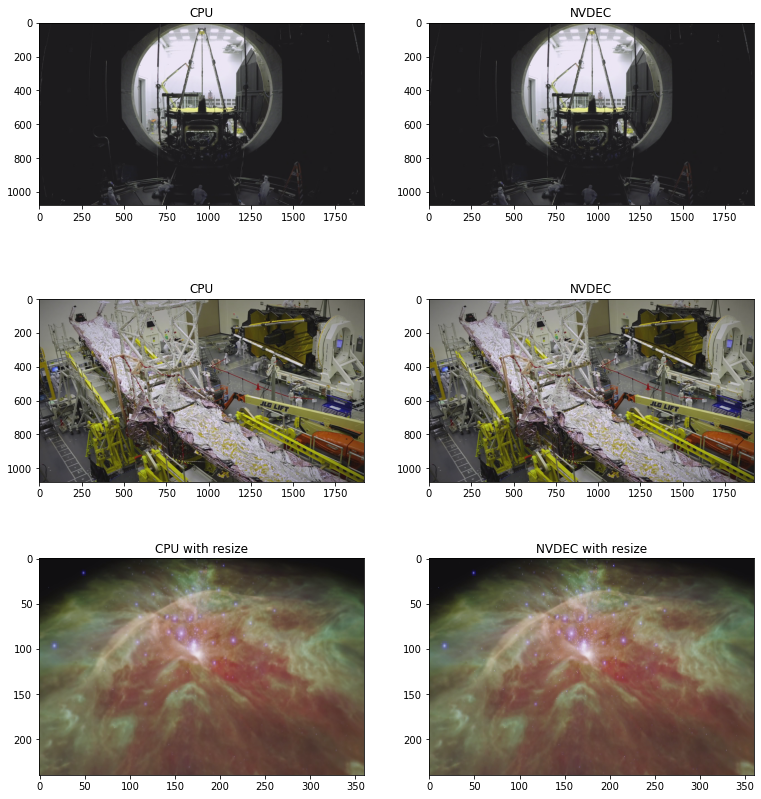

In [30]:
def yuv_to_rgb(img):
  img = img.cpu().to(torch.float)
  y = img[..., 0, :, :]
  u = img[..., 1, :, :]
  v = img[..., 2, :, :]

  y /= 255
  u = u / 255 - 0.5
  v = v / 255 - 0.5

  r = y + 1.14 * v
  g = y + -0.396 * u - 0.581 * v
  b = y + 2.029 * u

  rgb = torch.stack([r, g, b], -1)
  rgb = (rgb * 255).clamp(0, 255).to(torch.uint8)
  return rgb.numpy()


f, axs = plt.subplots(3, 2, figsize=[12.8, 14.4])
for i in range(3):
  for j in range(2):
    axs[i][j].imshow(yuv_to_rgb(samples[i][j]))
    axs[i][j].set_title(
        f"{'CPU' if j == 0 else 'NVDEC'}{' with resize' if i == 2 else ''}")
plt.plot(block=False)

## Conclusion

We looked at how to build FFmpeg libraries with NVDEC support and use it from TorchAudio. NVDEC provides significant speed up.